# Average Serial Interval

The goal of this notebook is to address another good point from **Reviewer 2**. The reviewer asks 'how many transmission events are thought to separate the cases that qualified for deep sequencing?' This is important for many aspects of our paper, so I'll attempt to address this by comparing the number of fixed mutations that separate sequences from one another compared to the expected distribution over multiple serial intervals. 

To address this, I'll use [Loiuse Moncla and Allie Black's implementation](https://github.com/lmoncla/ncov-WI-within-host/blob/master/scripts/calculate-probability-household-is-transmission-pair.ipynb) of a simple poisson model of the number mutations expected to accumulate over a single serial interval of infection. 

*A serial interval is the time between the onset of illness in the primary case and the onset of illness in the secondary case.*

The goal of this analysis is to determine how many serial intervals of infection separate the average case on the boat that qualified for deep-sequencing from the root of those sequences. This should help answer address whether many successive infections on the boat made it look like the bottleneck is more narrow than it was. 

In [1]:
from itertools import combinations, product
from collections import Counter

import numpy as np
import pandas as pd

from plotnine import *

from scipy.stats import poisson

from ete3 import Tree
from Bio import SeqIO

## Fixed Mutations on the Boat

Here, I'll determine which mutations have fixed on the boat relative to the inferred root node. I'll do this including the subset of three that includes the samples that qualified for deep-sequencing. 

In [2]:
# Files for the alignment, tree, and states for all boat sequences
alignment_file = "../../results/phylogeny/all-boat-sequences.aligned.fa"
tree_file = "../../results/phylogeny/all-boat-sequences.aligned.fa.treefile"
state_file = "../../results/phylogeny/all-boat-sequences.aligned.fa.state"

In [3]:
# Samples to exclude from the ancestral consensus (only works if they're outgroups of the clade.)
samples_to_exclude = ['10136', '10115', 'NC_045512.2']

# Import the tree including the global phylogeny with every boat sequence
tree = Tree(tree_file, format = 1)

# Get the node names for ancestral reconstruction
nodes_for_ancr = [n.name for n in tree.get_leaves() if n.name not in samples_to_exclude]

# Get the name of node to get difference relative to (a.k.a ancestral node for seqs of interest)
mrca = tree.get_common_ancestor(nodes_for_ancr).name.split("/")[0]

print(f"Finding the mutations relative to the ancestral sequenece at node == {mrca}, excluding samples: {samples_to_exclude}")


Finding the mutations relative to the ancestral sequenece at node == Node2, excluding samples: ['10136', '10115', 'NC_045512.2']


In [4]:
# Site offset relative to the start of the sequence
site_offset = 265

# Get the genome sequences for each tip
tip_to_seq = {record.id: list(str(record.seq).upper()) for record in SeqIO.parse(alignment_file, 'fasta')}
tip_states = (
    pd.DataFrame.from_dict(tip_to_seq, orient='index')
    .rename_axis('Node')
    .reset_index()
    .melt(id_vars='Node',
          var_name='Site',
          value_name='State',
          )
    .assign(Site=lambda x: x['Site'] + 1)
    )

# Import the internal states from IQtree `-asr` .state file
internal_states = (
    pd.read_csv(state_file,
                sep='\t',
                comment='#',
                usecols=['Node', 'Site', 'State'])
    )

# Combine and format the internal and tip states
states = (
    internal_states
    .append(tip_states)
    .assign(Site = lambda x: x['Site'] + site_offset, # to get the actual position
            n_states_at_site = lambda x: x.groupby('Site')['State'].transform('nunique'),
            )
    .query('n_states_at_site > 1')
    .drop(columns='n_states_at_site')
    )

states_dict = states.set_index(['Node', 'Site'])['State'].to_dict()

nodes = states['Node'].unique().tolist()

sites = sorted(states['Site'].unique())

# Find all pairwise differeces between the nodes/tips
subs_matrix = {}  # keyed by (parent, descendant)
for n1, n2 in product(nodes, nodes):
    subs = []
    for site in sites:
        nt1 = states_dict[(n1, site)]
        nt2 = states_dict[(n2, site)]
        if nt1 != nt2:
            if nt1 in {'A', 'C', 'G', 'T'} and nt2 in {'A', 'C', 'G', 'T'}:
                subs.append(f"{nt1}{site}{nt2}")
    subs_matrix[(n1, n2)] = subs

On average, how many differences separate the qualified sequences from the inferred MRCA? 

In [5]:
differences_from_root = list()
for k,v in subs_matrix.items():
    if k[0] == mrca and k[1] in nodes_for_ancr:
        print(f"There {'are' if len(v) !=1 else 'is'} {len(v)} mutations separating the root from {k[1]}.")
        differences_from_root.append(len(v))
        
differences_from_root_dist = Counter(differences_from_root)

There are 0 mutations separating the root from 10101.
There are 0 mutations separating the root from 10126.
There are 0 mutations separating the root from 10133.
There are 2 mutations separating the root from 10042.
There are 0 mutations separating the root from 10105.
There are 0 mutations separating the root from 10108.
There are 0 mutations separating the root from 10130.
There is 1 mutations separating the root from 10107.
There are 0 mutations separating the root from 10031.
There are 0 mutations separating the root from 10110.
There are 0 mutations separating the root from 10030.
There are 0 mutations separating the root from 10124.
There are 0 mutations separating the root from 10029.
There are 0 mutations separating the root from 10102.
There are 0 mutations separating the root from 10038.
There are 0 mutations separating the root from 10094.
There are 2 mutations separating the root from 10128.
There are 2 mutations separating the root from 10131.
There are 0 mutations separat

## Implementing the Poisson Model

For now, I'm using the same parameters used by [Loiuse Moncla and Allie Black](https://github.com/lmoncla/ncov-WI-within-host/blob/master/scripts/calculate-probability-household-is-transmission-pair.ipynb) in their model. I can test multiple parameters, or update these based on the current SARS-CoV-2 literature. 

I'll make a poisson distribution with a rate of mutation accumulation set around the average number of mutations expected to accumulate in a single serial interval (of [~5 days](https://www.nature.com/articles/s41591-020-0869-5)). The boat was only out to sea for 16 days. If the average serial interval is in the range of ~5 days, **there should have only been a maximum of ~3 serial intervals between the first and last infected indiviudals**. So, I'll look at the distribution of mutations expected to accumulate in 1, 2, and 3 serial intervals and compare that to the number of mutations actually observed.

In [6]:
## == Pameters for Distribution == ##

# Length of SARS-CoV-2 Reference
genome_length = 29903

# Average number of substitutions per site per year (interval is 7.03 × 10−4 and 1.5 × 10−3) from Duchene et al.
subs_per_site_per_year = 0.0011 
subs_per_genome_per_year = subs_per_site_per_year * genome_length 
subs_per_genome_per_day = subs_per_genome_per_year/365.25

# Average length of the serial interval for SARS-CoV-2 in days (95% CI is  4.8 to 6.8 days) from He et al.
serial_interval = 5.8 

# Average number of mutations in a serial interval: 
subs_per_genome_per_serial_interval = subs_per_genome_per_day * serial_interval

print(f"The average number of mutations expected to accumulate in a serial interval is: {subs_per_genome_per_serial_interval:.4f}")


The average number of mutations expected to accumulate in a serial interval is: 0.5223


In [7]:
# Convert the observed mutations into a dictionary of frequency
observed_mutations = {k: v/sum(v for v in differences_from_root_dist.values()) 
        for k,v in differences_from_root_dist.items()}

# Observed fixed mutations in the boat
observed_df = pd.DataFrame(data={'Mutations': [mut for mut in observed_mutations.keys()],
                              'Frequency': [freq for freq in observed_mutations.values()],
                              'Interval': "observed mutations"
                  })

In [8]:
theoretical_mutations = dict()
for interval in (np.arange(1, 4, 1) * serial_interval):
    # Poisson for each # of serial intervals
    rv = poisson(subs_per_genome_per_day * interval)
    # Get the probability mass function from 0 to 4 mutations
    theoretical_mutations[int(interval/serial_interval)] = rv.pmf(np.arange(0, 5, 1))
    
theoretical_list = list()
for k,v in theoretical_mutations.items():
    df = pd.DataFrame(data={'Mutations': np.arange(0, 5, 1),
                            'Frequency': v,
                            'Interval': f"{k} serial intervals"})
    theoretical_list.append(df)

theoretical_df =  pd.concat(theoretical_list)

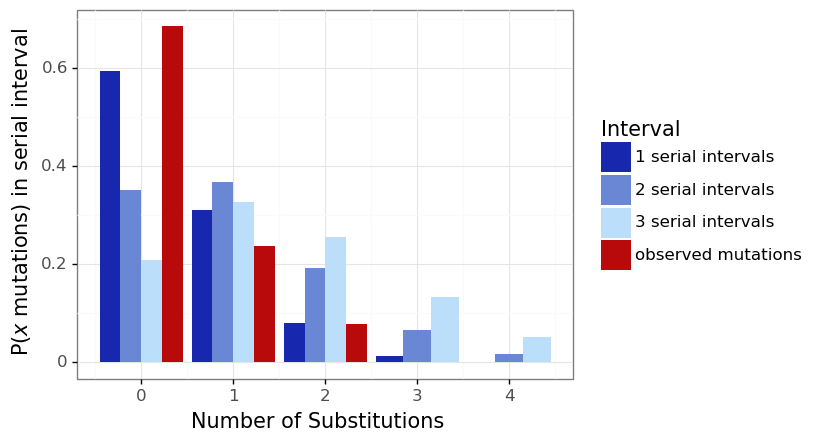

<ggplot: (8744703736141)>

In [9]:
poisson_plot = (
ggplot(pd.concat([observed_df, theoretical_df]), aes(x="Mutations", y="Frequency", fill="Interval"))
    + geom_bar(stat="identity", position="dodge")
    + ylab("P($x$ mutations) in serial interval")
    + xlab("Number of Substitutions")
    + scale_fill_manual(values = ("#1727AE", "#6987D5", "#BBDFFA", "#B80A0A"))
    + theme_bw(15)
)

poisson_plot

In [10]:
poisson_plot.save(filename = '../../results/figures/poisson-serial-interval.svg', height=5, width=7, units = 'in', dpi=300)

/home/whannon/miniconda3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 7 x 5 in image.
/home/whannon/miniconda3/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../results/figures/poisson-serial-interval.svg
